최고 점수 튜닝

빠른 학습을 위한 image -> npy 형태로 학습

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm import tqdm
import timm
from torchsummaryX import summary
from sklearn.model_selection import train_test_split, StratifiedKFold

from torch.utils.data import Dataset
from torch import nn

## Config

In [2]:
from dotenv import load_dotenv
from setup import get_package_root_path
from src.global_exception_handler.v1 import GlobalExceptionHandler
from src.webhook.v1 import TeamsWebhook

load_dotenv()

pakage_name = os.environ.get("PACKAGE_NAME")
root_path = get_package_root_path()

# 웹훅 알림 url (없으면 빈 문자열)
webhook_url = os.environ.get("WEBHOOK_URL")
webhook = TeamsWebhook(webhook_url)

# 핸들링할 예외 종류
except_tuple = (Exception,)
GlobalExceptionHandler(except_tuple=except_tuple, sender=webhook, name="dacon_cars")

In [3]:
!nvidia-smi

Sun Jun 18 13:45:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:81:00.0 Off |                  Off |
| 30%   36C    P3    78W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameter Setting

In [5]:
class CFG:
    root_path = root_path
    # Job Id (보통 파일명과 동일하게)
    job_id = "CLASSICIATION_5_submit_special_spark"

    # 원천 데이터 경로
    data_path = f"{root_path}/data/cars"

    # 학습의 결과물이 저장될 경로
    outputs_path = f"{root_path}/outputs/{job_id}"
    predict_dir = f"{outputs_path}/predict"
    recorder_dir = f"{outputs_path}/recorder"

    learning_late = 0.0001
    batch_size = 32
    epoch = 60
    num_classes = 34

    classes = [
        "chevrolet_malibu_sedan_2012_2016",
        "chevrolet_malibu_sedan_2017_2019",
        "chevrolet_spark_hatchback_2016_2021",
        "chevrolet_trailblazer_suv_2021_",
        "chevrolet_trax_suv_2017_2019",
        "genesis_g80_sedan_2016_2020",
        "genesis_g80_sedan_2021_",
        "genesis_gv80_suv_2020_",
        "hyundai_avante_sedan_2011_2015",
        "hyundai_avante_sedan_2020_",
        "hyundai_grandeur_sedan_2011_2016",
        "hyundai_grandstarex_van_2018_2020",
        "hyundai_ioniq_hatchback_2016_2019",
        "hyundai_sonata_sedan_2004_2009",
        "hyundai_sonata_sedan_2010_2014",
        "hyundai_sonata_sedan_2019_2020",
        "kia_carnival_van_2015_2020",
        "kia_carnival_van_2021_",
        "kia_k5_sedan_2010_2015",
        "kia_k5_sedan_2020_",
        "kia_k7_sedan_2016_2020",
        "kia_mohave_suv_2020_",
        "kia_morning_hatchback_2004_2010",
        "kia_morning_hatchback_2011_2016",
        "kia_ray_hatchback_2012_2017",
        "kia_sorrento_suv_2015_2019",
        "kia_sorrento_suv_2020_",
        "kia_soul_suv_2014_2018",
        "kia_sportage_suv_2016_2020",
        "kia_stonic_suv_2017_2019",
        "renault_sm3_sedan_2015_2018",
        "renault_xm3_suv_2020_",
        "ssangyong_korando_suv_2019_2020",
        "ssangyong_tivoli_suv_2016_2020",
    ]


CFG.__dict__

mappingproxy({'__module__': '__main__',
              'root_path': '/data/dacon_cars',
              'job_id': 'CLASSICIATION_5_submit_special_spark',
              'data_path': '/data/dacon_cars/data/cars',
              'outputs_path': '/data/dacon_cars/outputs/CLASSICIATION_5_submit_special_spark',
              'predict_dir': '/data/dacon_cars/outputs/CLASSICIATION_5_submit_special_spark/predict',
              'recorder_dir': '/data/dacon_cars/outputs/CLASSICIATION_5_submit_special_spark/recorder',
              'learning_late': 0.0001,
              'batch_size': 32,
              'epoch': 60,
              'num_classes': 34,
              'classes': ['chevrolet_malibu_sedan_2012_2016',
               'chevrolet_malibu_sedan_2017_2019',
               'chevrolet_spark_hatchback_2016_2021',
               'chevrolet_trailblazer_suv_2021_',
               'chevrolet_trax_suv_2017_2019',
               'genesis_g80_sedan_2016_2020',
               'genesis_g80_sedan_2021_',
        

## CustomDataset

In [6]:
from sklearn.utils.class_weight import compute_class_weight


class CustomDataset(Dataset):
    def __init__(self, X, y, transforms=None, num_classes: int = None):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.num_classes = num_classes

    def to_categorical(self, y, num_classes):
        """1-hot encodes a tensor"""
        return np.eye(num_classes, dtype="uint8")[y]

    def get_class_weight(self):
        return torch.Tensor(
            compute_class_weight(
                class_weight="balanced", classes=np.unique(self.y), y=self.y
            )
        )

    def __getitem__(self, index):
        img_path = self.X[index]
        image = cv2.cvtColor(np.load(img_path), cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        if self.y is None:  # if test
            return image, img_path

        # train or valid
        label = self.y[index]
        if self.num_classes is None:
            return image, label, img_path
        else:
            return image, self.to_categorical(label, self.num_classes), img_path

    def __len__(self):
        return len(self.X)

## Transforms

In [7]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        A.ShiftScaleRotate(
            shift_limit=0,
            rotate_limit=7,
            border_mode=0,
            value=(0, 0, 0),
            p=0.5,
        ),
        A.ToGray(p=1),
        A.HorizontalFlip(),
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=(3, 25), p=1),
                A.GaussNoise(p=1),
                A.Sharpen(p=1),
                A.Equalize(p=1),
            ],
            p=0.9,
        ),
        A.HueSaturationValue(val_shift_limit=10, p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1),
        A.OneOf(
            [
                A.CoarseDropout(fill_value=255, max_height=25, max_width=25),
                A.CoarseDropout(fill_value=128, max_height=25, max_width=25),
                A.CoarseDropout(fill_value=0, max_height=25, max_width=25),
            ],
            p=1,
        ),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        A.ToGray(p=1),
        # A.GaussianBlur(blur_limit=(3, 21), p=1),
        # A.HueSaturationValue(),
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

## Init dataset

In [8]:
data = None
for i, cls in enumerate(range(CFG.num_classes)):
    data_path_list = sorted(glob(f"{CFG.data_path}/{cls}/*.npy"))
    data_path_list = np.expand_dims(np.array(data_path_list), 1)

    labels = np.ones(data_path_list.shape, dtype=np.uint8) * i

    temp = np.concatenate([data_path_list, labels], axis=1)

    data = temp if data is None else np.concatenate([data, temp], axis=0)

In [9]:
df = pd.DataFrame(data)
df.columns = ["path", "label"]
df = df.astype({"path": "string", "label": "int"})
df

,path,label
0,/data/dacon_cars/data/cars/0/syn_00024_2.npy,0
1,/data/dacon_cars/data/cars/0/syn_00053_1.npy,0
2,/data/dacon_cars/data/cars/0/syn_00060_1.npy,0
3,/data/dacon_cars/data/cars/0/syn_00061_1.npy,0
4,/data/dacon_cars/data/cars/0/syn_00077_1.npy,0
...,...,...
16995,/data/dacon_cars/data/cars/33/syn_06341_0.npy,33
16996,/data/dacon_cars/data/cars/33/syn_06347_0.npy,33
16997,/data/dacon_cars/data/cars/33/syn_06434_2.npy,33
16998,/data/dacon_cars/data/cars/33/syn_06437_0.npy,33


In [10]:
for i, cls in enumerate(range(CFG.num_classes)):
    print(f'{cls} : {df[df["label"] == i].shape[0]}')

print("")
print(f"전체 : {df.shape[0]}")

0 : 500
1 : 500
2 : 500
3 : 500
4 : 500
5 : 500
6 : 500
7 : 500
8 : 500
9 : 500
10 : 500
11 : 500
12 : 500
13 : 500
14 : 500
15 : 500
16 : 500
17 : 500
18 : 500
19 : 500
20 : 500
21 : 500
22 : 500
23 : 500
24 : 500
25 : 500
26 : 500
27 : 500
28 : 500
29 : 500
30 : 500
31 : 500
32 : 500
33 : 500

전체 : 17000


## Train / Validation Split

In [11]:
data_fold_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
checker = data_fold_splitter.get_n_splits(X=df, y=df["label"])
print(checker)

5


In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score


def save_pred(saved_path, path, y_true, y_pred, y_prob=None):
    os.makedirs(saved_path)

    df_data = [path, y_true, y_pred]
    df_columns = ["path", "y_true", "y_pred"]

    if y_prob != None:
        df_data.append(y_prob)
        df_columns.append("y_prob")

    df = pd.DataFrame(np.array(df_data).T)
    df.columns = df_columns

    df.to_csv(f"{saved_path}/pred.csv", index=False)

    ### 임시 confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.set(rc={"figure.figsize": (21, 21)})
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    _val_score = f1_score(y_true, y_pred, average="macro")
    plt.xlabel(f"Pred / F1-score: {_val_score:.3f}")
    plt.ylabel("Real")

    classes_point = list(map(lambda x: x + 0.5, range(CFG.num_classes)))
    classes = list(range(CFG.num_classes))
    plt.xticks(classes_point, classes)
    plt.yticks(classes_point, classes)
    plt.savefig(f"{saved_path}/c_matrix.jpg")
    plt.clf()

## Valid

In [13]:
from src.image_eda.v1 import tensor2im
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    confusion_matrix,
)


def valid(model, criterion, data_loader, device):
    model.eval()
    val_loss = []

    epoch_paths = []
    y_true = []
    y_pred = []
    # y_probs = []
    with torch.no_grad():
        for batch_index, (images, labels, paths) in enumerate(tqdm(data_loader)):
            if batch_index % 10 == 0:
                temp_img = images[0].cpu().detach()
                temp_img = tensor2im(temp_img)

                cv2.imwrite(f"{CFG.root_path}/temp/valid_img.jpg", temp_img)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            probs = model(images)
            loss = criterion(probs, labels)

            probs = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            preds = np.argmax(probs, 1).astype(np.uint8)
            labels = np.argmax(labels, 1).astype(np.uint8)

            preds = preds.flatten()
            labels = labels.flatten()

            y_pred += preds.tolist()
            y_true += labels.tolist()
            # y_probs += probs.tolist()
            epoch_paths += paths

            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_score = accuracy_score(y_true, y_pred)

    return {
        "val_loss": val_loss,
        "val_score": val_score,
        "path": epoch_paths,
        "y_true": y_true,
        "y_pred": y_pred,
    }

## Train

In [14]:
def train(model, criterion, optimizer, data_loader, device, grad_scaler=None):
    model.train()
    train_loss = []

    epoch_paths = []
    y_true = []
    y_pred = []
    for batch_index, (images, labels, paths) in enumerate(tqdm(data_loader)):
        if batch_index % 10 == 0:
            temp_img = images[0].detach().cpu()
            temp_img = tensor2im(temp_img)

            cv2.imwrite(f"{CFG.root_path}/temp/train_img.jpg", temp_img)

        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        if grad_scaler is None:
            probs = model(images)
            loss = criterion(probs, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                probs = model(images)
                loss = criterion(probs, labels)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

        probs = probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        preds = np.argmax(probs, 1).astype(np.uint8)
        labels = np.argmax(labels, 1).astype(np.uint8)

        preds = preds.flatten()
        labels = labels.flatten()

        y_pred += preds.tolist()
        y_true += labels.tolist()
        epoch_paths += paths

        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_score = accuracy_score(y_true, y_pred)

    return {
        "train_loss": train_loss,
        "train_score": train_score,
    }

## Model Define

In [15]:
def create_model(num_classes: int) -> nn.Module:
    # model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.DEFAULT)
    # model.classifier = nn.Sequential(nn.Linear(2048, num_classes), nn.Softmax())

    # model = timm.models.eva.eva02_base_patch14_448(pretrained=True)
    # model.head = nn.Sequential(
    #     nn.Linear(768, ),
    #     nn.BatchNorm1d(),
    #     nn.GELU(),
    #     nn.Dropout(0.5),
    #     nn.Linear(768, num_classes),
    # )

    # model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.DEFAULT)
    # model.classifier[2] = nn.Sequential(
    #     nn.Linear(1536, 1024),
    #     nn.LayerNorm(1024),
    #     nn.SiLU(),
    #     nn.Dropout1d(0.5),
    #     nn.Linear(1024, num_classes),
    # )

    model = timm.models.convnext.convnext_large(pretrained=True)
    model.head.fc = nn.Sequential(
        nn.Linear(1536, 768),
        nn.LayerNorm(768),
        nn.SiLU(),
        nn.Dropout(0.5),
        nn.Linear(768, num_classes),
    )

    return model


create_model(34)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

## Snapshot Notebook

In [ ]:
import shutil

try:
    import IPython

    notebook_path = IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
except:
    notebook_path = f"{os.getcwd()}/{CFG.job_id}.ipynb"


os.makedirs(CFG.outputs_path, exist_ok=True)
shutil.copy(notebook_path, f"{CFG.outputs_path}/{os.path.split(notebook_path)[1]}")

## Run!!

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
from src.random_seed.v1 import seed_everything, seed_worker

seed_everything(0)

In [18]:
grad_scaler = torch.cuda.amp.GradScaler()

In [ ]:
from src.recorder.v1 import Recorder
from time import time


for fold_index, (train_idx, valid_idx) in enumerate(
    data_fold_splitter.split(X=df, y=df["label"])
):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[valid_idx]

    train_dataset = CustomDataset(
        train_df["path"].values,
        train_df["label"].values,
        train_transform,
        CFG.num_classes,
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=16,  #
        pin_memory=True,
        drop_last=False,
        worker_init_fn=seed_worker,
    )
    #
    val_dataset = CustomDataset(
        val_df["path"].values, val_df["label"].values, val_transform, CFG.num_classes
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=16,
        pin_memory=True,
        drop_last=False,
        worker_init_fn=seed_worker,
    )
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG.learning_late)
    scheduler = None

    recorder = Recorder(
        f"{CFG.recorder_dir}/fold_{fold_index}", model, optimizer, scheduler
    )
    print(f"fold_{fold_index} start")
    if recorder.load_checkpoint(device, "checkpoint.pt"):
        print(f"loaded current_epoch: {recorder.current_epoch}")

    criterion = nn.CrossEntropyLoss()

    best_val_loss = 100
    for epoch_index in range(recorder.current_epoch, CFG.epoch):
        seed_everything(epoch_index)

        train_start_timestamp = time()
        train_dict = train(
            model, criterion, optimizer, train_loader, device, grad_scaler
        )
        train_elapsed_time = time() - train_start_timestamp

        val_start_timestamp = time()
        val_dict = valid(model, criterion, val_loader, device)
        val_elapsed_time = time() - val_start_timestamp

        recorder.update_row_dict("epoch", epoch_index + 1)

        recorder.update_row_dict("train_loss", train_dict["train_loss"])
        recorder.update_row_dict("val_loss", val_dict["val_loss"])

        recorder.update_row_dict("train_score", train_dict["train_score"])
        recorder.update_row_dict("val_score", val_dict["val_score"])

        recorder.update_row_dict("train_elapsed_time", train_elapsed_time)
        recorder.update_row_dict("val_elapsed_time", val_elapsed_time)
        recorder.flush_row_dict(is_print=True)
        recorder.save_line_plot(["loss"], [0, 0.1])

        save_pred(
            f"{CFG.predict_dir}/fold_{fold_index}/{epoch_index+1}",
            val_dict["path"],
            val_dict["y_true"],
            val_dict["y_pred"],
        )

        if recorder.is_best_score(val_dict["val_loss"], "min"):
            print(f"best epoch: {epoch_index + 1}")
            recorder.save_checkpoint(epoch_index, "best_model.pt")

        recorder.save_checkpoint(epoch_index)

## Test

In [19]:
def get_smaller_box_with_iou_threshold(box1, box2, iou_threshold=0.1):
    # box1 = (x1, y1, x2, y2)
    # box2 = (x1, y1, x2, y2)

    # 상자1의 좌표 추출
    x1_box1, y1_box1, x2_box1, y2_box1 = box1
    # 상자2의 좌표 추출
    x1_box2, y1_box2, x2_box2, y2_box2 = box2

    # 상자1의 면적 계산
    area_box1 = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    # 상자2의 면적 계산
    area_box2 = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)

    # 상자1과 상자2의 겹치는 영역 계산
    x_left = max(x1_box1, x1_box2)
    y_top = max(y1_box1, y1_box2)
    x_right = min(x2_box1, x2_box2)
    y_bottom = min(y2_box1, y2_box2)

    # 겹치는 영역의 면적 계산
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # IoU 계산
    iou = intersection_area / float(area_box1 + area_box2 - intersection_area)

    # IoU가 지정한 임계값 이상인 경우, 더 작은 상자 index를 반환
    if iou >= iou_threshold:
        if area_box1 < area_box2:
            return 0
        else:
            return 1
    else:
        return None

In [20]:
print(get_smaller_box_with_iou_threshold((0, 0, 9, 9), (2, 2, 5, 5)))

1


In [21]:
test_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        # A.RandomBrightnessContrast(p=1),
        A.ToGray(p=1),
        A.Equalize(by_channels=False, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

In [22]:
model_list = []
import ttach as tta

tta_transforms = tta.Compose(
    [
        # tta.FiveCrops(350, 350),
        # tta.Rotate90(angles=[0, 180]),
        # tta.Scale(scales=[1, 2, 4]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),
        tta.HorizontalFlip(),
    ]
)

for i in range(0, 5):
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()

    check_point = torch.load(
        f"{CFG.recorder_dir}/fold_{i}/best_model.pt",
        map_location=device,
    )
    print(check_point["epoch"])
    print(check_point["best_score"])
    model.load_state_dict(check_point["model"])
    model.eval()
    tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
    model_list.append(tta_model)

# for i in range(0, 5):
#     model = create_model(CFG.num_classes)
#     model.to(device)
#     model.cuda()

#     check_point = torch.load(
#         f"{CFG.recorder_dir}/fold_{i}/checkpoint.pt",
#         map_location=device,
#     )
#     print(check_point["epoch"])
#     print(check_point["best_score"])
#     model.load_state_dict(check_point["model"])
#     model.eval()
#     tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
#     model_list.append(tta_model)

30
1.7036442084849384e-05
30
3.274208869119762e-05
32
2.9324548024951837e-05
20
8.47781902678511e-06
31
2.2524611565225134e-05


In [27]:
test_index = 0  # 656

/data/dacon_cars/data/test_cars/155231127_0.npy
0
(252, 246, 3)
[[0.    0.    0.001 0.    0.061 0.003 0.001 0.    0.545 0.201 0.    0.001
  0.004 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.178
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
0.545
spark: 0.24300000071525574
gene: 0.0010000000474974513
8
hyundai_avante_sedan_2011_2015


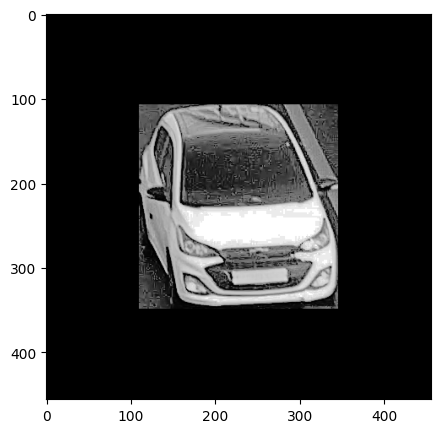

In [29]:
from torch.nn import functional as F


# test_list = sorted(glob("/data/dacon_cars/data/test_cars/*.npy"))
test_list = sorted(glob("/data/dacon_cars/data/test_cars/155231127_0.npy"))
print(test_list[test_index])
print(test_index)
img = cv2.cvtColor(np.load(test_list[test_index]), cv2.COLOR_BGR2RGB)
# test_index += 1
with torch.no_grad():
    print(img.shape)
    img = img[5:-5, 5:-5]
    test_img = test_transform(image=img)["image"]
    test_img = torch.Tensor(test_img).to(device, dtype=torch.float)
    test_img = torch.unsqueeze(test_img, 0)
    ensemble_probs = None
    for tta_model in model_list:
        probs = F.softmax(tta_model(test_img), dim=1)
        probs = np.round(probs.cpu().detach().numpy(), 3)

        if ensemble_probs is None:
            ensemble_probs = probs
        else:
            ensemble_probs = ensemble_probs + probs

    ensemble_probs = np.round(ensemble_probs / len(model_list), 3)

    top1 = np.max(ensemble_probs)
    label = np.argmax(ensemble_probs)
    spark_score = ensemble_probs[0][4] + ensemble_probs[0][12] + ensemble_probs[0][23]

    gene = ensemble_probs[0][6] + ensemble_probs[0][7]

    print(ensemble_probs)
    print(top1)
    print(f"spark: {spark_score}")
    print(f"gene: {gene}")
    print(label)
    print(CFG.classes[label])
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor2im(test_img[0]))
    # f"{test_path}/test"

In [30]:
bbox_submit = pd.read_csv("/data/dacon_cars/data/bbox_submit_npy.csv")
filenames = sorted(os.listdir("/data/dacon_cars/data/test"))

total_list = []
for target in tqdm(iter(filenames)):
    car_info_df = bbox_submit[
        (bbox_submit["file_name"] == target)
        # & ((bbox_submit["point3_x"] - bbox_submit["point1_x"]) <= 370)
        # & ((bbox_submit["point3_y"] - bbox_submit["point1_y"]) <= 441)
    ]
    # print(one_test)
    # if "064507368" not in target:
    #     continue

    infer_list = []
    for i, car_info in car_info_df.iterrows():
        file_name = car_info["file_name"]

        img = cv2.cvtColor(
            cv2.imread(f"/data/dacon_cars/data/test/{file_name}"),
            cv2.COLOR_BGR2RGB,
        )
        pt1x = int(np.round(car_info["point1_x"])) + 5
        pt1y = int(np.round(car_info["point1_y"])) + 5
        pt2x = int(np.round(car_info["point2_x"])) - 5
        pt2y = int(np.round(car_info["point2_y"])) + 5
        pt3x = int(np.round(car_info["point3_x"])) - 5
        pt3y = int(np.round(car_info["point3_y"])) - 5
        pt4x = int(np.round(car_info["point4_x"])) + 5
        pt4y = int(np.round(car_info["point4_y"])) - 5

        img = img[pt1y:pt3y, pt1x:pt3x]
        with torch.no_grad():
            img = test_transform(image=img)["image"]
            img = torch.Tensor(img).to(device, dtype=torch.float)
            img = torch.unsqueeze(img, 0)
            ensemble_probs = None
            for tta_model in model_list:
                probs = F.softmax(tta_model(img), dim=1)
                probs = np.round(probs.cpu().detach().numpy(), 3)

                if ensemble_probs is None:
                    ensemble_probs = probs
                else:
                    ensemble_probs = ensemble_probs + probs

            ensemble_probs = np.round(ensemble_probs / len(model_list), 3)

        # for j in range(len(ensemble_probs)):
        #     ensemble_probs[j][2] = (
        #         ensemble_probs[j][4] + ensemble_probs[j][12] + ensemble_probs[j][23]
        #     )
        # if "075817746" in file_name:
        #     print(file_name)
        class_id = np.argmax(ensemble_probs)
        confidence = ensemble_probs[0][class_id]
        spark_score = (
            ensemble_probs[0][4] + ensemble_probs[0][12] + ensemble_probs[0][23]
        )

        infer_list.append(
            [
                file_name,
                class_id,
                confidence,
                pt1x,
                pt1y,
                pt2x,
                pt2y,
                pt3x,
                pt3y,
                pt4x,
                pt4y,
                spark_score,
            ]
        )

    infer_array = np.array(infer_list)
    max_confidence_list = []
    try:
        # if len(np.where(infer_array.T[2].astype(float) > 0.99)[0]) > 1:
        high_confi = np.where(infer_array.T[2].astype(float) >= 0.999)[0]
        if len(high_confi) > 1:
            print(target)
            print(infer_array)

            box1 = infer_array[high_confi][0]
            box2 = infer_array[high_confi][1]

            smaller_index = get_smaller_box_with_iou_threshold(
                (int(box1[3]), int(box1[4]), int(box1[7]), int(box1[8])),
                (int(box2[3]), int(box2[4]), int(box2[7]), int(box2[8])),
            )
            print(smaller_index)

            if smaller_index is None:  # 안겹침
                # total_list.append(infer_array[np.argmax(infer_array.T[2])].tolist())
                total_list.append(box1.tolist())
                total_list.append(box2.tolist())
            else:
                if smaller_index == 0:
                    total_list.append(box1.tolist())
                else:
                    total_list.append(box2.tolist())
            continue

        top_score = float(infer_array[np.argmax(infer_array.T[2])][2])
        if top_score < 0.65:
            new_spark = infer_array[np.argmax(infer_array.T[11])].tolist()

            if top_score <= float(new_spark[11]):
                new_spark[1] = 2
                total_list.append(new_spark)
                print(target)
                print(f"new_spark!: {new_spark}")
                continue

        total_list.append(infer_array[np.argmax(infer_array.T[2])].tolist())

    except Exception as e:
        print(e)
        print(car_info)

    # total_list.append(max_confidence_list.copy())

124it [00:38,  3.69it/s]

075817746.png
new_spark!: ['075817746.png', 2, '0.346', '796', '312', '1028', '312', '1028', '578', '796', '578', '0.548']


192it [00:57,  2.82it/s]

082220349.png
new_spark!: ['082220349.png', 2, '0.598', '1241', '464', '1489', '464', '1489', '732', '1241', '732', '0.99899995']


208it [01:01,  2.84it/s]

082653535.png
new_spark!: ['082653535.png', 2, '0.547', '804', '240', '1031', '240', '1031', '492', '804', '492', '0.911']


215it [01:04,  3.38it/s]

082940472.png
new_spark!: ['082940472.png', 2, '0.331', '1169', '245', '1403', '245', '1403', '504', '1169', '504', '0.765']


221it [01:06,  3.07it/s]

083026406.png
new_spark!: ['083026406.png', 2, '0.544', '477', '544', '720', '544', '720', '833', '477', '833', '0.77000004']


228it [01:08,  3.63it/s]

083235511.png
new_spark!: ['083235511.png', 2, '0.546', '1154', '159', '1385', '159', '1385', '396', '1154', '396', '0.867']


258it [01:17,  1.65it/s]

084258536.png
new_spark!: ['084258536.png', 2, '0.604', '522', '412', '752', '412', '752', '667', '522', '667', '0.816']


272it [01:21,  3.63it/s]

084536952.png
new_spark!: ['084536952.png', 2, '0.526', '417', '382', '634', '382', '634', '639', '417', '639', '0.79300004']


319it [01:36,  3.34it/s]

085636462.png
new_spark!: ['085636462.png', 2, '0.461', '790', '241', '1016', '241', '1016', '489', '790', '489', '0.78499997']


350it [01:45,  3.67it/s]

090453226.png
new_spark!: ['090453226.png', 2, '0.502', '812', '406', '1052', '406', '1052', '670', '812', '670', '0.90199995']


390it [01:57,  2.10it/s]

091356569.png
new_spark!: ['091356569.png', 2, '0.371', '937', '638', '1187', '638', '1187', '913', '937', '913', '0.79']


410it [02:03,  2.66it/s]

091809733.png
[['091809733.png' '11' '1.0' '740' '176' '1016' '176' '1016' '505' '740'
  '505' '0.0']
 ['091809733.png' '11' '1.0' '1254' '421' '1558' '421' '1558' '771'
  '1254' '771' '0.0']]
None


417it [02:05,  3.55it/s]

091927022.png
new_spark!: ['091927022.png', 2, '0.431', '1217', '353', '1459', '353', '1459', '606', '1217', '606', '0.776']


520it [02:38,  3.55it/s]

093738733.png
new_spark!: ['093738733.png', 2, '0.214', '435', '312', '665', '312', '665', '573', '435', '573', '0.611']


586it [02:59,  3.56it/s]

095458342.png
new_spark!: ['095458342.png', 2, '0.375', '1272', '555', '1526', '555', '1526', '822', '1272', '822', '0.832']


659it [03:22,  3.59it/s]

100932883.png
new_spark!: ['100932883.png', 2, '0.534', '1142', '161', '1371', '161', '1371', '414', '1142', '414', '0.79499996']


671it [03:26,  2.65it/s]

101129586.png
new_spark!: ['101129586.png', 2, '0.391', '954', '635', '1204', '635', '1204', '913', '954', '913', '0.81700003']


738it [03:47,  2.15it/s]

102355327.png
new_spark!: ['102355327.png', 2, '0.304', '1249', '333', '1489', '333', '1489', '592', '1249', '592', '0.69']


788it [04:02,  3.46it/s]

102947977.png
new_spark!: ['102947977.png', 2, '0.4', '912', '467', '1155', '467', '1155', '748', '912', '748', '0.798']


811it [04:09,  2.25it/s]

103254450.png
new_spark!: ['103254450.png', 2, '0.438', '1225', '266', '1458', '266', '1458', '504', '1225', '504', '0.832']


832it [04:16,  3.38it/s]

103648046.png
new_spark!: ['103648046.png', 2, '0.417', '1193', '229', '1424', '229', '1424', '471', '1193', '471', '0.742']


902it [04:37,  3.57it/s]

104943288.png
new_spark!: ['104943288.png', 2, '0.413', '1140', '110', '1364', '110', '1364', '335', '1140', '335', '0.788']


970it [04:59,  2.61it/s]

110017426.png
new_spark!: ['110017426.png', 2, '0.318', '1189', '173', '1440', '173', '1440', '440', '1189', '440', '0.31999996']


1055it [05:27,  2.83it/s]

111503789.png
new_spark!: ['111503789.png', 2, '0.4', '1312', '404', '1558', '404', '1558', '665', '1312', '665', '0.776']


1088it [05:37,  3.58it/s]

112000484.png
new_spark!: ['112000484.png', 2, '0.519', '439', '267', '647', '267', '647', '498', '439', '498', '0.93299997']


1241it [06:30,  3.07it/s]

113525669.png
new_spark!: ['113525669.png', 2, '0.307', '564', '794', '845', '794', '845', '1072', '564', '1072', '0.308']


1302it [06:49,  2.69it/s]

114154699.png
new_spark!: ['114154699.png', 2, '0.433', '986', '568', '1233', '568', '1233', '851', '986', '851', '0.768']


1341it [07:03,  2.80it/s]

114631813.png
new_spark!: ['114631813.png', 2, '0.648', '1260', '332', '1500', '332', '1500', '585', '1260', '585', '0.989']


1356it [07:09,  2.09it/s]

114751838.png
new_spark!: ['114751838.png', 2, '0.414', '1514', '762', '1788', '762', '1788', '1059', '1514', '1059', '0.727']


1367it [07:13,  3.31it/s]

114910760.png
new_spark!: ['114910760.png', 2, '0.359', '838', '317', '1072', '317', '1072', '578', '838', '578', '0.608']


1428it [07:34,  3.57it/s]

115748182.png
new_spark!: ['115748182.png', 2, '0.244', '1572', '753', '1846', '753', '1846', '1040', '1572', '1040', '0.672']


1448it [07:42,  2.36it/s]

120224068.png
[['120224068.png' '20' '1.0' '1249' '333' '1524' '333' '1524' '590'
  '1249' '590' '0.0']
 ['120224068.png' '16' '1.0' '778' '211' '1061' '211' '1061' '515' '778'
  '515' '0.0']]
None


1453it [07:43,  3.32it/s]

120307823.png
new_spark!: ['120307823.png', 2, '0.352', '818', '251', '1048', '251', '1048', '500', '818', '500', '0.73600006']


1516it [08:05,  3.10it/s]

121214700.png
new_spark!: ['121214700.png', 2, '0.564', '789', '118', '1007', '118', '1007', '347', '789', '347', '0.982']


1544it [08:14,  3.54it/s]

121729012.png
new_spark!: ['121729012.png', 2, '0.323', '1246', '296', '1482', '296', '1482', '548', '1246', '548', '0.685']


1597it [08:31,  3.47it/s]

122601972.png
new_spark!: ['122601972.png', 2, '0.533', '1269', '302', '1506', '302', '1506', '557', '1269', '557', '0.94799995']


1679it [09:02,  2.51it/s]

123718050.png
[['123718050.png' '10' '1.0' '805' '185' '1063' '185' '1063' '432' '805'
  '432' '0.0']
 ['123718050.png' '28' '1.0' '1543' '749' '1859' '749' '1859' '1071'
  '1543' '1071' '0.0']]
None


1702it [09:08,  3.47it/s]

124157654.png
new_spark!: ['124157654.png', 2, '0.248', '1295', '288', '1532', '288', '1532', '545', '1295', '545', '0.686']


1733it [09:20,  2.60it/s]

124738887.png
new_spark!: ['124738887.png', 2, '0.403', '1288', '366', '1531', '366', '1531', '630', '1288', '630', '0.75699997']


1755it [09:28,  1.86it/s]

125050159.png
[['125050159.png' '24' '0.999' '860' '378' '1101' '378' '1101' '664'
  '860' '664' '0.0']
 ['125050159.png' '24' '1.0' '1187' '131' '1414' '131' '1414' '388'
  '1187' '388' '0.0']]
None


1763it [09:31,  3.41it/s]

125214831.png
new_spark!: ['125214831.png', 2, '0.533', '1213', '240', '1445', '240', '1445', '489', '1213', '489', '0.806']


1764it [09:31,  3.47it/s]

125215532.png
new_spark!: ['125215532.png', 2, '0.394', '1439', '672', '1705', '672', '1705', '967', '1439', '967', '0.493']


1870it [10:06,  2.97it/s]

130842428.png
new_spark!: ['130842428.png', 2, '0.421', '1261', '265', '1497', '265', '1497', '521', '1261', '521', '0.832']


1922it [10:23,  2.53it/s]

131828533.png
new_spark!: ['131828533.png', 2, '0.453', '482', '459', '714', '459', '714', '719', '482', '719', '0.906']


1953it [10:33,  2.77it/s]

132327630.png
new_spark!: ['132327630.png', 2, '0.55', '881', '434', '1121', '434', '1121', '701', '881', '701', '0.653']


1977it [10:42,  3.59it/s]

132639025.png
new_spark!: ['132639025.png', 2, '0.368', '952', '531', '1200', '531', '1200', '813', '952', '813', '0.621']


2081it [11:17,  2.85it/s]

134120027.png
new_spark!: ['134120027.png', 2, '0.59', '449', '410', '683', '410', '683', '656', '449', '656', '0.81499994']


2110it [11:29,  2.34it/s]

134457909.png
[['134457909.png' '24' '1.0' '1040' '602' '1301' '602' '1301' '911'
  '1040' '911' '0.0']
 ['134457909.png' '24' '1.0' '807' '89' '1032' '89' '1032' '351' '807'
  '351' '0.0']]
None


2150it [11:41,  3.46it/s]

135040213.png
new_spark!: ['135040213.png', 2, '0.452', '471', '460', '691', '460', '691', '713', '471', '713', '0.781']


2166it [11:46,  2.96it/s]

135235756.png
new_spark!: ['135235756.png', 2, '0.632', '813', '152', '1035', '152', '1035', '397', '813', '397', '0.902']


2182it [11:51,  3.01it/s]

135442921.png
new_spark!: ['135442921.png', 2, '0.466', '414', '230', '637', '230', '637', '473', '414', '473', '0.75899994']


2191it [11:54,  2.73it/s]

135633953.png
new_spark!: ['135633953.png', 2, '0.599', '1203', '156', '1428', '156', '1428', '387', '1203', '387', '0.944']


2212it [12:01,  3.40it/s]

135845550.png
new_spark!: ['135845550.png', 2, '0.608', '1223', '176', '1450', '176', '1450', '426', '1223', '426', '0.89599997']


2326it [12:41,  2.92it/s]

141432407.png
new_spark!: ['141432407.png', 2, '0.556', '791', '153', '1016', '153', '1016', '389', '791', '389', '0.937']


2355it [12:50,  3.53it/s]

141814412.png
new_spark!: ['141814412.png', 2, '0.643', '754', '125', '977', '125', '977', '365', '754', '365', '0.88600004']


2392it [13:04,  3.25it/s]

142308548.png
new_spark!: ['142308548.png', 2, '0.564', '781', '128', '1003', '128', '1003', '360', '781', '360', '0.977']


2414it [13:11,  3.06it/s]

142625451.png
new_spark!: ['142625451.png', 2, '0.437', '819', '182', '1043', '182', '1043', '426', '819', '426', '0.78']


2540it [13:56,  3.59it/s]

144127193.png
new_spark!: ['144127193.png', 2, '0.502', '819', '244', '1046', '244', '1046', '495', '819', '495', '0.693']


2541it [13:56,  3.59it/s]

144128099.png
new_spark!: ['144128099.png', 2, '0.372', '953', '589', '1201', '589', '1201', '856', '953', '856', '0.802']


2566it [14:05,  2.73it/s]

144511700.png
new_spark!: ['144511700.png', 2, '0.487', '802', '113', '1018', '113', '1018', '339', '802', '339', '0.853']


2580it [14:10,  2.50it/s]

144807536.png
new_spark!: ['144807536.png', 2, '0.403', '1225', '224', '1456', '224', '1456', '467', '1225', '467', '0.786']


2592it [14:14,  3.57it/s]

145009670.png
new_spark!: ['145009670.png', 2, '0.536', '481', '449', '719', '449', '719', '709', '481', '709', '0.82000005']


2599it [14:16,  3.63it/s]

145207740.png
new_spark!: ['145207740.png', 2, '0.644', '1270', '309', '1508', '309', '1508', '564', '1270', '564', '0.843']


2603it [14:17,  3.64it/s]

145307671.png
new_spark!: ['145307671.png', 2, '0.449', '1189', '177', '1419', '177', '1419', '419', '1189', '419', '0.66999996']


2620it [14:23,  2.96it/s]

145637747.png
new_spark!: ['145637747.png', 2, '0.624', '840', '232', '1067', '232', '1067', '489', '840', '489', '0.77000004']


2622it [14:23,  3.28it/s]

145719875.png
new_spark!: ['145719875.png', 2, '0.51', '1451', '638', '1715', '638', '1715', '913', '1451', '913', '0.71']


2638it [14:29,  2.25it/s]

150026259.png
[['150026259.png' '30' '1.0' '962' '643' '1234' '643' '1234' '898' '962'
  '898' '0.0']
 ['150026259.png' '4' '1.0' '798' '245' '1047' '245' '1047' '513' '798'
  '513' '1.0']]
None


2673it [14:42,  2.69it/s]

150624990.png
[['150624990.png' '12' '1.0' '714' '5' '1009' '5' '1009' '203' '714'
  '203' '1.0']
 ['150624990.png' '12' '1.0' '714' '5' '948' '5' '948' '203' '714' '203'
  '1.0']]
1


2679it [14:44,  2.46it/s]

150722394.png
new_spark!: ['150722394.png', 2, '0.581', '815', '105', '1036', '105', '1036', '333', '815', '333', '0.919']


2721it [14:58,  3.61it/s]

151403452.png
new_spark!: ['151403452.png', 2, '0.627', '805', '127', '1027', '127', '1027', '370', '805', '370', '0.86099994']


2745it [15:07,  3.16it/s]

151819461.png
new_spark!: ['151819461.png', 2, '0.499', '1146', '87', '1369', '87', '1369', '311', '1146', '311', '0.92700005']


2757it [15:11,  2.23it/s]

152123129.png
new_spark!: ['152123129.png', 2, '0.495', '824', '304', '1054', '304', '1054', '570', '824', '570', '0.749']


2760it [15:13,  2.54it/s]

152332968.png
new_spark!: ['152332968.png', 2, '0.538', '806', '85', '1022', '85', '1022', '314', '806', '314', '0.972']


2763it [15:14,  2.31it/s]

152415267.png
new_spark!: ['152415267.png', 2, '0.397', '802', '155', '1021', '155', '1021', '390', '802', '390', '0.65']


2767it [15:16,  2.61it/s]

152528869.png
new_spark!: ['152528869.png', 2, '0.488', '805', '230', '1031', '230', '1031', '474', '805', '474', '0.68299997']


2823it [15:34,  3.00it/s]

154154250.png
new_spark!: ['154154250.png', 2, '0.492', '432', '253', '659', '253', '659', '493', '432', '493', '0.87100005']


2864it [15:48,  3.34it/s]

154730787.png
new_spark!: ['154730787.png', 2, '0.444', '1188', '238', '1422', '238', '1422', '483', '1188', '483', '0.55300003']


3002it [16:38,  1.70it/s]

161544056.png
[['161544056.png' '27' '0.403' '1161' '152' '1431' '152' '1431' '426'
  '1161' '426' '0.028']
 ['161544056.png' '28' '1.0' '672' '5' '913' '5' '913' '220' '672' '220'
  '0.0']
 ['161544056.png' '26' '0.384' '1411' '499' '1748' '499' '1748' '985'
  '1411' '985' '0.011']
 ['161544056.png' '28' '1.0' '671' '5' '990' '5' '990' '220' '671' '220'
  '0.0']]
0


3103it [17:20,  2.65it/s]

163730466.png
[['163730466.png' '28' '1.0' '661' '5' '902' '5' '902' '218' '661' '218'
  '0.0']
 ['163730466.png' '28' '1.0' '661' '5' '983' '5' '983' '219' '661' '219'
  '0.0']]
0


3284it [18:52,  1.57it/s]

173904351.png
[['173904351.png' '30' '1.0' '365' '260' '612' '260' '612' '496' '365'
  '496' '0.0']
 ['173904351.png' '13' '0.639' '1145' '81' '1400' '81' '1400' '346'
  '1145' '346' '0.001']
 ['173904351.png' '21' '0.999' '808' '286' '1065' '286' '1065' '578'
  '808' '578' '0.0']]
None


3400it [19:46,  2.87it/s]


In [31]:
submit_df = pd.DataFrame(
    total_list,
    columns=[
        "file_name",
        "class_id",
        "confidence",
        "point1_x",
        "point1_y",
        "point2_x",
        "point2_y",
        "point3_x",
        "point3_y",
        "point4_x",
        "point4_y",
        "spark_score",
    ],
)

# submit_df.astype(
#     {
#         "file_name": "string",
#         "class_id": "int",
#         "confidence": "float",
#         "point1_x": "float",
#         "point1_y": "float",
#         "point2_x": "float",
#         "point2_y": "float",
#         "point3_x": "float",
#         "point3_y": "float",
#         "point4_x": "float",
#         "point4_y": "float",
#     }
# )
submit_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y,spark_score
0,064442001.png,16,0.999,1142,183,1431,183,1431,493,1142,493,0.0
1,064507368.png,16,0.876,494,127,762,127,762,425,494,425,0.001
2,065131036.png,3,1.0,1112,58,1359,58,1359,317,1112,317,0.0
3,065147868.png,16,0.998,729,189,1013,189,1013,496,729,496,0.0
4,065203472.png,8,1.0,539,767,831,767,831,1044,539,1044,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3402,183730886.png,1,1.0,1325,599,1617,599,1617,870,1325,870,0.0
3403,183744509.png,1,0.8,915,697,1205,697,1205,978,915,978,0.0
3404,183911746.png,27,1.0,756,274,1004,274,1004,558,756,558,0.0
3405,183928410.png,27,1.0,689,52,918,52,918,303,689,303,0.0


In [32]:
submit_df.to_csv("/data/submit_spark_score_보정_재현1.csv", index=False)
submit_df = pd.read_csv("/data/submit_spark_score_보정_재현1.csv")

In [ ]:
img = cv2.imread(f"/data/dacon_cars/data/test/134457909.png")
img = img[5:-5, 5:-5]
img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
print(img.shape)
plt.imshow(img)

In [ ]:
submit_df[(submit_df["file_name"] == "161544056.png")]

In [33]:
submit_df[(submit_df["class_id"] == 2)]  #  & (submit_df["confidence"] < 0.7)

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y,spark_score
123,075817746.png,2,0.346,796,312,1028,312,1028,578,796,578,0.548
191,082220349.png,2,0.598,1241,464,1489,464,1489,732,1241,732,0.999
207,082653535.png,2,0.547,804,240,1031,240,1031,492,804,492,0.911
214,082940472.png,2,0.331,1169,245,1403,245,1403,504,1169,504,0.765
220,083026406.png,2,0.544,477,544,720,544,720,833,477,833,0.770
...,...,...,...,...,...,...,...,...,...,...,...,...
2765,152332968.png,2,0.538,806,85,1022,85,1022,314,806,314,0.972
2768,152415267.png,2,0.397,802,155,1021,155,1021,390,802,390,0.650
2772,152528869.png,2,0.488,805,230,1031,230,1031,474,805,474,0.683
2828,154154250.png,2,0.492,432,253,659,253,659,493,432,493,0.871


In [ ]:
i = 0

In [34]:
submit_df = pd.read_csv("/data/submit_spark_score_보정_재현1.csv")

# data = submit_df[
#     (submit_df["class_id"] == 23)
#     & (submit_df["confidence"] < 0.999)
#     & (submit_df["confidence"] > 0.99)
# ].iloc[i]

# file_name = data["file_name"]
# score = data["confidence"]
# i += 1

# print(score)
# img = cv2.imread(f"/data/dacon_cars/data/test/{file_name}")
# img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
# plt.figure(figsize=(15, 15))
# plt.imshow(img)


submit_df.loc[
    submit_df[
        (submit_df["class_id"] == 12) & (submit_df["confidence"] < 0.65)
    ].index.to_list(),
    "class_id",
] = 2

submit_df.loc[
    submit_df[
        (submit_df["class_id"] == 4) & (submit_df["confidence"] < 0.65)
    ].index.to_list(),
    "class_id",
] = 2

submit_df.loc[
    submit_df[
        (submit_df["class_id"] == 8) & (submit_df["confidence"] < 0.65)
    ].index.to_list(),
    "class_id",
] = 2

submit_df.loc[
    submit_df[
        (submit_df["class_id"] == 22) & (submit_df["confidence"] < 0.65)
    ].index.to_list(),
    "class_id",
] = 2

submit_df.loc[
    submit_df[
        (submit_df["class_id"] == 27) & (submit_df["confidence"] < 0.65)
    ].index.to_list(),
    "class_id",
] = 2

submit_df.loc[
    submit_df[
        (submit_df["class_id"] == 23) & (submit_df["confidence"] < 0.99)
    ].index.to_list(),
    "class_id",
] = 2


# submit_df.loc[
#     submit_df[
#         (submit_df["confidence"] < 0.7)
#         &(submit_df["class_id"] == 4)
#         &(submit_df["class_id"] == 8)
#         &(submit_df["class_id"] == 11)
#         &(submit_df["class_id"] == 15)
#         &(submit_df["class_id"] == 20)
#         &(submit_df["class_id"] == 27)
#         &(submit_df["class_id"] == 33)
#     ].index.to_list(),
#     "class_id",
# ] = 2

# submit_df.loc[
#     submit_df[
#         (submit_df["confidence"] < 0.999)
#         &(submit_df["class_id"] == 23)
#     ].index.to_list(),
#     "class_id",
# ] = 2

# 12 빠짐
# # 26 < 0.5
# # 4, 11, 8, 15, 20, 27, 33 < 0.7
# # 23 < 0.99

submit_df.to_csv("/data/submit_spark_score_보정_재현2.csv", index=False)

In [ ]:
from torch.nn import functional as F


# test_list = sorted(glob("/data/dacon_cars/data/test_cars/*.npy"))
test_list = sorted(glob("/data/dacon_cars/data/test_cars/155231127_1.npy"))
print(test_list[test_index])
print(test_index)
img = cv2.cvtColor(np.load(test_list[test_index]), cv2.COLOR_BGR2RGB)
# test_index += 1
with torch.no_grad():
    print(img.shape)
    img = img[5:-5, 5:-5]
    test_img = test_transform(image=img)["image"]
    test_img = torch.Tensor(test_img).to(device, dtype=torch.float)
    test_img = torch.unsqueeze(test_img, 0)
    ensemble_probs = None
    for tta_model in model_list:
        probs = F.softmax(tta_model(test_img), dim=1)
        probs = np.round(probs.cpu().detach().numpy(), 3)

        if ensemble_probs is None:
            ensemble_probs = probs
        else:
            ensemble_probs = ensemble_probs + probs

    ensemble_probs = np.round(ensemble_probs / len(model_list), 3)

    top1 = np.max(ensemble_probs)
    label = np.argmax(ensemble_probs)
    spark_score = ensemble_probs[0][4] + ensemble_probs[0][12] + ensemble_probs[0][23]

    gene = ensemble_probs[0][6] + ensemble_probs[0][7]

    print(ensemble_probs)
    print(top1)
    print(f"spark: {spark_score}")
    print(f"gene: {gene}")
    print(label)
    print(CFG.classes[label])
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor2im(test_img[0]))
    # f"{test_path}/test"

In [ ]:
submit_df = pd.read_csv("/data/submit_special_spark.csv").iloc[:, 1:]
submit_df

from src.image_eda.v1 import apply_bbox

for i, row in tqdm(submit_df.iterrows()):
    img = cv2.imread(f"/data/dacon_cars/data/test/{row['file_name']}")

    img = apply_bbox(
        img,
        [row["class_id"] + 1],
        [[row["point1_x"], row["point1_y"], row["point3_x"], row["point3_y"]]],
        CFG.classes,
        [row["confidence"]],
        [0, 255, 0],
    )

    cv2.imwrite(
        f"/data/dacon_cars/data/draw_bbox/{row['file_name'].replace('.png', '.jpg')}",
        img,
    )

In [ ]:
import shutil

for i, row in submit_df[submit_df["class_id"] == 2].iterrows():
    shutil.copy(
        f"/data/dacon_cars/data/test_cars_image/{row['file_name'].replace('.png', '_0.png')}",
        f"/data/dacon_cars/data/export/{row['file_name'].replace('.png', '_0.png')}",
    )

In [ ]:
plt.figure(figsize=(15, 15))
plt.hist(submit_df["class_id"], 34)

In [ ]:
submit2_df = pd.read_csv("/data/submit2.csv")

In [ ]:
compare_df = pd.concat(
    [submit_df["file_name"], submit_df["class_id"], submit2_df["class_id"]],
    axis=1,
)

compare_df = pd.merge(
    submit_df[["file_name", "class_id"]],
    submit2_df[["file_name", "class_id"]],
    how="outer",
    left_index=True,
    right_index=True,
    indicator=True,
)

compare_df.columns = ["file_name", "class_id1", "class_id2"]
compare_df

In [ ]:
print(compare_df.compare(compare_df, align_axis=1))  # index